In [990]:
##########################################################################################
#################################### IMPORT LIBRARIES ####################################
##########################################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import datetime
import os
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from scipy.stats import chi2

In [991]:
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [992]:
##########################################################################################
#################################### FUNCTIONS & DATA ####################################
##########################################################################################

############ Date & Time

current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d-%H%M")  # Concatenate date and time without separators

############ Load IntCal20

intcal20 = pd.read_csv('./Data/IntCal20.csv')
ref = intcal20["CRA"]
sd_ref = intcal20["sd_CRA"]
mean_sd_ref = 20

############ Century Suffix

def get_century_suffix(century_end):
    if century_end in [100, 200, 300]:
        return {100: 'st', 200: 'nd', 300: 'rd'}[century_end]
    else:
        return 'th'

############ GENERATE SETS OF CALENDAR DATES

def generate_calendar_dates(century_end, span, spacing):
    stop_year = random.randint(century_end - 100 + span, century_end)
    calendar_dates = np.arange(stop_year - span,  stop_year , spacing)
    return calendar_dates

############ Chi-Squared Table

p=0.05
chi_table = pd.DataFrame()
chi_table['sample_nr'] = np.arange(2,51,1)
chi_table['df'] = chi_table['sample_nr'] - 1
chi_table['chi'] = chi2.isf(p, chi_table['df'])
chi_table.index = chi_table['sample_nr']
chi_table = chi_table.drop(['sample_nr'], axis=1)

############ GENERATE OXCAL CODE FUNCTION

def generate_oxcal_code(ids, radiocarbon_dates, errors, gap):
    code = "Plot()\n{\n"
    code += "D_Sequence()\n{\n"  
    for i in range(len(radiocarbon_dates)):
        code += f"    R_Date(\"{ids[i]}\", {radiocarbon_dates[i]}, {errors[i]});\n"
        if i < len(radiocarbon_dates) - 1:
            code += f"    Gap({gap});\n"
    code += "};\n};"  
    return code


In [993]:
#################################################################################################
#################################### GENERATE CALENDAR DATES ####################################
#################################################################################################

# Define the different types of sets and their parameters
sets_of_calendar_dates = [
    {"Code": "SA", "Span": 10, "Spacing": 1},
    {"Code": "SB", "Span": 10, "Spacing": 2},
    {"Code": "SQ", "Span": 10, "Spacing": 5},
    {"Code": "MA", "Span": 25, "Spacing": 1},
    {"Code": "MB", "Span": 25, "Spacing": 2},
    {"Code": "MQ", "Span": 25, "Spacing": 5},
    {"Code": "LA", "Span": 50, "Spacing": 1},
    {"Code": "LB", "Span": 50, "Spacing": 2},
    {"Code": "LQ", "Span": 50, "Spacing": 5},
]

# Generate sets of calendar dates for each century within the last 2000 years
generated_dates = []
for century_end in range(1900, 0, -100):
    for set_info in sets_of_calendar_dates:
        code = set_info["Code"]
        span = set_info["Span"]
        spacing = set_info["Spacing"]

        calendar_dates = generate_calendar_dates(century_end, span, spacing)

        # Store the generated calendar dates for the current set and century
        generated_dates.append({
            "Century": f"{century_end//100}{get_century_suffix(century_end)}",
            "Type" : f"{code}",
            "Calendar Dates": calendar_dates.tolist(), 
        })

# Save the generated dates in a Data Frame
df = pd.DataFrame(generated_dates)
df['Ring Nr'] = df['Calendar Dates'].apply(lambda row: [abs(max(row) - val) for val in row])
df['Bark Edge'] = df['Calendar Dates'].apply(lambda row: max(row))


In [994]:
####################################################################################################
#################################### SIMULATE RADIOCARBON DATES ####################################
####################################################################################################

# Load the R package oxcAAR
oxcAAR = importr('oxcAAR')

# Set the path to the OxCal executable 

###################
## TO RUN THIS CELL
## REPLACE "/Users/andrea/OxCal/bin/OxCalMac" 
## WITH THE ACTUAL OXCAL PATH ON YOUR SYSTEM
#################

ro.r('setOxcalExecutablePath("/Users/andrea/OxCal/bin/OxCalMac")')

# Convert Python DataFrame to R DataFrame
pandas2ri.activate()

# Function to simulate radiocarbon dates for each row in the DataFrame
def simulate_radiocarbon_dates(row):
    calendar_dates_iter = pd.DataFrame({
        "Year": row["Calendar Dates"],
        "SD": [mean_sd_ref] * len(row["Calendar Dates"]),
        "Name": ['Date'] * len(row["Calendar Dates"])
    })

    calendar_dates_r = pandas2ri.py2rpy(calendar_dates_iter)
    ro.r.assign("Year", calendar_dates_r.rx(True, 1))
    ro.r.assign("SD", calendar_dates_r.rx(True, 2))
    ro.r.assign("Name", calendar_dates_r.rx(True, 3))
    ro.r('simulated_dates <- oxcalSimulate(c_date = Year, std = SD, names = Name)')
    ro.r('radiocarbon_dates <- data.frame(CRA=get_bp(simulated_dates))')
    ro.r('radiocarbon_stdev <- data.frame(sd_CRA=get_std(simulated_dates))')
    radiocarbon_dates = pandas2ri.rpy2py(ro.r('radiocarbon_dates'))
    radiocarbon_stdev = pandas2ri.rpy2py(ro.r('radiocarbon_stdev'))
    
    # Convert factor values to integers
    radiocarbon_dates = [int(float(ro.r['as.numeric'](date)[0])) for date in radiocarbon_dates["CRA"]]
    radiocarbon_stdev = [int(float(ro.r['as.numeric'](sd)[0])) for sd in radiocarbon_stdev["sd_CRA"]]

    return radiocarbon_dates, radiocarbon_stdev

# Apply the function to simulate radiocarbon dates for each row in the DataFrame
df[["Radiocarbon Dates", "Radiocarbon Error"]] = df.apply(simulate_radiocarbon_dates, axis=1, result_type="expand")





R[write to console]: Oxcal path set!



OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
O

## OXCAL CALIBRATION

In [995]:
###########################################################################################
#################################### OXCAL CALIBRATION ####################################
###########################################################################################

# Initialize a list to store the oxcal ranges for each n
oxcal_ranges = []

# Iterate over each value of n
for n in range(len(df)):
    radiocarbon_dates = df['Radiocarbon Dates'][n]
    errors = df['Radiocarbon Error'][n]
    ids = [f'D{k}' if k != len(df['Radiocarbon Dates'][n])-1 else 'D_Felling' for k in range(len(df['Radiocarbon Dates'][n]))]
    gap = df['Calendar Dates'][n][len(df['Calendar Dates'][n]) - 1] - df['Calendar Dates'][n][len(df['Calendar Dates'][n]) - 2]

    # Generate OxCal code
    oxcal_code = generate_oxcal_code(ids, radiocarbon_dates, errors, gap)

    # Convert the OxCal code (oxcal_code) to an R string
    ro.r.assign("oxcal_code_r", oxcal_code)

    # Run the executeOxcalScript function from oxcAAR
    ro.r('''
    library(oxcAAR)
    knitr::opts_chunk$set(cache=TRUE)
    results <- executeOxcalScript(oxcal_code_r)
    ''')

    # Retrieve the results back to Python
    results = ro.r['results']

    # Get the path to the result file
    results_path = ro.r['results'][0]

    # Read the contents of the JSON file
    with open(results_path, 'r') as file:
        file_contents = file.read()

    # Split the file contents into lines
    file_lines = file_contents.split('\n')

    # Initialize lists to store relevant information
    likelihood_comments = []

    # Iterate over each line in the file
    for line in file_lines:
        # Check if the line contains a likelihood comment
        if "posterior.comment" in line:
            # Extract the likelihood comment
            comment = line.split("=")[-1].strip().strip('";')
            likelihood_comments.append(comment)

    # Initialize lists to store data
    d_data = []
    current_d = None

    # Iterate over each likelihood comment
    for comment in likelihood_comments:
        # Check if the comment contains D variable information
        if comment.startswith("D"):
            # If it's not the first D variable, append the current data to d_data
            if current_d is not None:
                d_data.append(current_d)
            # Initialize current_d with the new D variable information
            current_d = {'D_Variable': comment.strip()}
            current_d['Year_Ranges'] = []
        # If the comment contains year range information, store it under current_d
        elif "AD" in comment:
            # Use regular expressions to extract the year range values
            match = re.match(r"\s+(\d+)AD \((\d+\.\d+)%\) (\d+)AD", comment)
            if match:
                current_d['Year_Ranges'].append({
                    'Percentage': float(match.group(2)),
                    'Start_Year': int(match.group(1)),
                    'End_Year': int(match.group(3))
                })

    # Append the last D variable data
    if current_d is not None:
        d_data.append(current_d)

    # Create DataFrame for D variable data
    d_df = pd.DataFrame(d_data)

    # Extract D variable name from 'D_Variable' column
    d_df['D_Variable'] = d_df['D_Variable'].str.split(' ').str[0]

    # Expand the Year_Ranges list into separate rows
    expanded_d_df = d_df.explode('Year_Ranges')

    # Extract the year range values into separate columns
    expanded_d_df = pd.concat([expanded_d_df.drop(['Year_Ranges'], axis=1), expanded_d_df['Year_Ranges'].apply(pd.Series)], axis=1)

    sequence_data = expanded_d_df[expanded_d_df['D_Variable'] == 'D_Felling']

    # Calculate min Start_Year and max End_Year
    min_start_year = sequence_data['Start_Year'].min()
    max_end_year = sequence_data['End_Year'].max()

    oxcal_ranges.append([int(min_start_year), int(max_end_year)])

# Add the oxcal ranges as a new column in the DataFrame
df['Oxcal Range'] = oxcal_ranges

oxcal_ranges_size = []

for n in range(len(df)):
    oxcal_range_size = df['Oxcal Range'][n][1] - df['Oxcal Range'][n][0]
    oxcal_ranges_size.append(oxcal_range_size)

df['Ox Range Size'] = oxcal_ranges_size

ox_inrange = []

for n in range(len(df)):
    bark_edge = df['Bark Edge'][n]
    oxcal_range_min = df['Oxcal Range'][n][0]
    oxcal_range_max = df['Oxcal Range'][n][1]

    # Check if bark_edge is within the oxcal range
    if oxcal_range_min <= bark_edge <= oxcal_range_max:
        res = True
    else:
        res = False

    ox_inrange.append(res)

df['Ox in-Range'] = ox_inrange

ox_re_counts = df['Ox in-Range'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

print(ox_re_counts)


OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
OxCal v4.4.4 (c) Bronk Ramsey (2021)
O

## $\chi^2$

In [996]:
#################################################################################################
#################################### CHI SQUARED CALIBRATION ####################################
#################################################################################################

#perc = 1
df['Chi_result'] = ''
df['Chi_range_sum'] = ''
df['Chi_best_estimate'] = ''
df['Chi_error'] = ''
chi_and_years = []

for n in range(len(df)):
    #r_length = df['Oxcal Range'][n][1] - df['Oxcal Range'][n][0]
    #ext = int(perc * r_length)
    end_year = min(df['Oxcal Range'][n][1]+100, 1950)
    test_range = range(df['Oxcal Range'][n][0]-100, end_year)
    
    Chi_result = np.zeros(len(test_range))
    Year_result = np.zeros(len(test_range))

    R = df['Radiocarbon Dates'][n]
    delta_R = df['Radiocarbon Error'][n]
    r = df['Ring Nr'][n]
    C = intcal20['CRA']
    delta_C = intcal20['sd_CRA']

    for x in test_range:
        for i in range(len(R)):
            diff = x - r[i]
            if diff >0:
                year_idx = diff
            else:
                year_idx = diff-1 # IntCal20 doesn't have year 0!
            numerator = ((R[i]) - (C[intcal20['year_CE'] == year_idx])) ** 2
            denominator = ((delta_R[i]) ** 2 + (delta_C[intcal20['year_CE'] == year_idx]) ** 2)
            Chi_result[x - min(test_range)] += numerator / denominator
        Year_result[x - min(test_range)] = x

    min_chi_value = np.min(Chi_result)
    mask_min_chi = np.array(Chi_result) == min_chi_value
    colors = np.where(mask_min_chi, 'forestgreen', 'dodgerblue')

    chi_and_years.append({
            "Years": Year_result,
            "Chi" : Chi_result, 
            "Colour" : colors,
        })

    #passed_years = Year_result[Chi_result < chi_table['chi'][len(df['Radiocarbon Dates'][n])]]

    result = 'Passed' if min_chi_value < chi_table['chi'][len(df['Radiocarbon Dates'][n])] else 'Failed'

    ##### CALCULATE RANGES
    likelihoods = np.exp(-Chi_result / 2)
    total_likelihood = np.sum(likelihoods)
    sorted_indices = np.argsort(-likelihoods)
    sorted_likelihoods = likelihoods[sorted_indices]
    sorted_years = Year_result[sorted_indices]

    cumulative_likelihood = 0
    cumulative_years = []
    for i, likelihood in enumerate(sorted_likelihoods):
        cumulative_likelihood += likelihood
        cumulative_years.append(sorted_years[i])
        if cumulative_likelihood >= 0.954 * total_likelihood:
            break
##########


    df.at[n, 'Chi_result'] = result
    df.at[n, 'Chi_best_estimate'] = Year_result[Chi_result==min_chi_value].tolist()
    chi_best_estimate = df['Chi_best_estimate'][n]
    chi_error = [df['Bark Edge'][n] - estimate for estimate in chi_best_estimate]
    df.at[n, 'Chi_error'] = chi_error
    #df.at[n, 'Chi_range'] = passed_years.tolist()
    df.at[n, 'Chi_range_sum'] = cumulative_years
    
    chi_range_sum = df['Chi_range_sum'][n]
    if chi_range_sum:  # Check if the list is not empty
        df.at[n, 'Chi_range_sum_size'] = max(chi_range_sum) - min(chi_range_sum)
    else:
        df.at[n, 'Chi_range_sum_size'] = None  # or any other value to represent an empty range



df_chi = pd.DataFrame(chi_and_years)
chi_value_counts = df['Chi_result'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print(chi_value_counts)

Passed    99.4%
Failed     0.6%
Name: Chi_result, dtype: object


# SAVE & VISUALISE RESULTS

In [998]:
############################################################
####################### SAVE RESULTS #######################
############################################################

df.to_excel(f'./Data/Results/results_{formatted_datetime}.xlsx')


In [999]:
df

,Century,Type,Calendar Dates,Ring Nr,Bark Edge,Radiocarbon Dates,Radiocarbon Error,Oxcal Range,Ox Range Size,Ox in-Range,Chi_result,Chi_range_sum,Chi_best_estimate,Chi_error,Chi_range_sum_size
0,19th,SA,"[1830, 1831, 1832, 1833, 1834, 1835, 1836, 183...","[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",1839,"[118, 66, 56, 117, 71, 131, 155, 128, 124, 91]","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]","[1704, 1922]",218,True,Passed,"[1911.0, 1910.0, 1912.0, 1837.0, 1838.0, 1909....",[1911.0],[-72.0],210.0
1,19th,SB,"[1868, 1870, 1872, 1874, 1876]","[8, 6, 4, 2, 0]",1876,"[145, 90, 78, 137, 87]","[20, 20, 20, 20, 20]","[1697, 1918]",221,True,Passed,"[1820.0, 1819.0, 1821.0, 1822.0, 1823.0, 1706....",[1820.0],[56.0],219.0
2,19th,SQ,"[1886, 1891]","[5, 0]",1891,"[134, 74]","[20, 20]","[1693, 1917]",224,True,Passed,"[1894.0, 1893.0, 1816.0, 1817.0, 1892.0, 1895....",[1894.0],[-3.0],221.0
3,19th,MA,"[1826, 1827, 1828, 1829, 1830, 1831, 1832, 183...","[24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 1...",1850,"[119, 65, 51, 108, 59, 117, 142, 116, 113, 81,...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[1841, 1936]",95,True,Passed,"[1925.0, 1924.0, 1926.0, 1923.0, 1851.0, 1922....",[1925.0],[-75.0],80.0
4,19th,MB,"[1837, 1839, 1841, 1843, 1845, 1847, 1849, 185...","[24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]",1861,"[139, 90, 79, 136, 84, 142, 162, 133, 127, 92,...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[1840, 1894]",54,True,Passed,"[1850.0, 1852.0, 1851.0, 1853.0, 1849.0, 1854....",[1850.0],[11.0],80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,1st,MB,"[37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 5...","[24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]",61,"[1973, 1964, 1993, 1921, 1982, 1982, 1989, 198...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[40, 74]",34,True,Passed,"[62.0, 61.0, 63.0, 60.0, 64.0, 59.0, 58.0, 65....",[62.0],[-1.0],26.0
167,1st,MQ,"[43, 48, 53, 58, 63]","[20, 15, 10, 5, 0]",63,"[1977, 1972, 2003, 1924, 1973]","[20, 20, 20, 20, 20]","[30, 84]",54,True,Passed,"[67.0, 68.0, 69.0, 70.0, 66.0, 71.0, 65.0, 72....",[67.0],[-4.0],51.0
168,1st,LA,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 3...",55,"[2039, 2001, 2028, 2008, 1988, 2004, 2007, 200...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[48, 64]",16,True,Passed,"[56.0, 57.0, 55.0, 58.0, 53.0, 54.0, 52.0, 59....",[56.0],[-1.0],9.0
169,1st,LB,"[28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 5...","[48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 2...",76,"[2001, 1961, 1988, 1969, 1951, 1969, 1974, 197...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[68, 85]",17,True,Passed,"[75.0, 76.0, 77.0, 74.0, 73.0, 78.0, 72.0, 79....",[75.0],[1.0],14.0


# BOXPLOTS

In [1002]:
directory_overview = f"./Figures/Overview/{formatted_datetime}"
if not os.path.exists(directory_overview):
    os.makedirs(directory_overview)

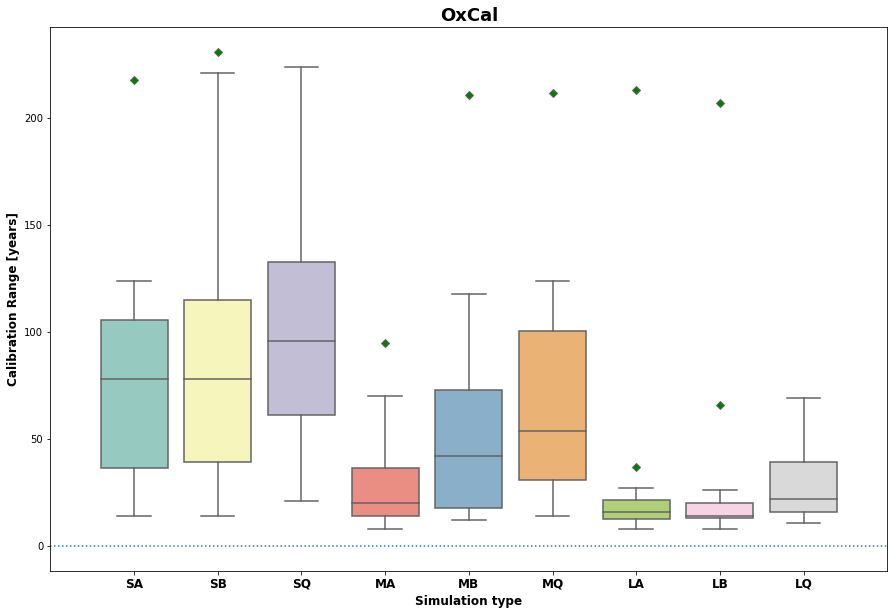

In [1003]:

###### OXCAL BOXPLOT

df_box_oxcal = df.explode('Ox Range Size')
df_box_oxcal['Ox Range Size'] = pd.to_numeric(df_box_oxcal['Ox Range Size'])
df_box_oxcal['Ox Range Size'] = abs(df_box_oxcal['Ox Range Size'])

fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(data=df_box_oxcal, x='Type', y='Ox Range Size', ax=ax, flierprops=dict(markerfacecolor='g', marker='D'), palette="Set3")
ax.hlines(0, -1, 10, linestyles='dotted')

# Set labels and title
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
ax.set_ylabel('Calibration Range [years]', fontsize=12, fontweight='bold')
ax.set_xlabel('Simulation type', fontsize=12, fontweight='bold')
ax.set_title('OxCal', fontsize=18, fontweight='bold')

# Set x-axis limits
ax.set_xlim(-1, 9)
#ax.set_ylim(-1,50)

# Save and show the plot
plt.savefig(f'./Figures/Overview/{formatted_datetime}/boxplot_oxcal.jpg', bbox_inches='tight', pad_inches=0.5, dpi=200)
plt.show()


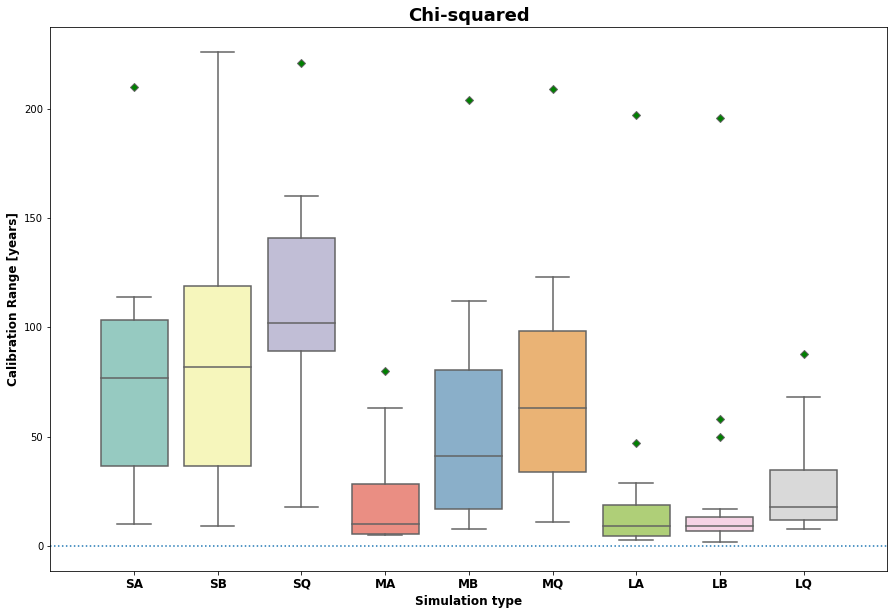

In [1004]:

###### CHI RANGE BOXPLOT

df_box_oxcal = df.explode('Chi_range_sum_size')
df_box_oxcal['Chi_range_sum_size'] = pd.to_numeric(df_box_oxcal['Chi_range_sum_size'])
df_box_oxcal['Chi_range_sum_size'] = abs(df_box_oxcal['Chi_range_sum_size'])

fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(data=df_box_oxcal, x='Type', y='Chi_range_sum_size', ax=ax, flierprops=dict(markerfacecolor='g', marker='D'), palette="Set3")
ax.hlines(0, -1, 10, linestyles='dotted')

# Set labels and title
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
ax.set_ylabel('Calibration Range [years]', fontsize=12, fontweight='bold')
ax.set_xlabel('Simulation type', fontsize=12, fontweight='bold')
ax.set_title('Chi-squared', fontsize=18, fontweight='bold')

# Set x-axis limits
ax.set_xlim(-1, 9)
#ax.set_ylim(-1,50)

# Save and show the plot
plt.savefig(f'./Figures/Overview/{formatted_datetime}/boxplot_chi_range.jpg', bbox_inches='tight', pad_inches=0.5, dpi=200)
plt.show()


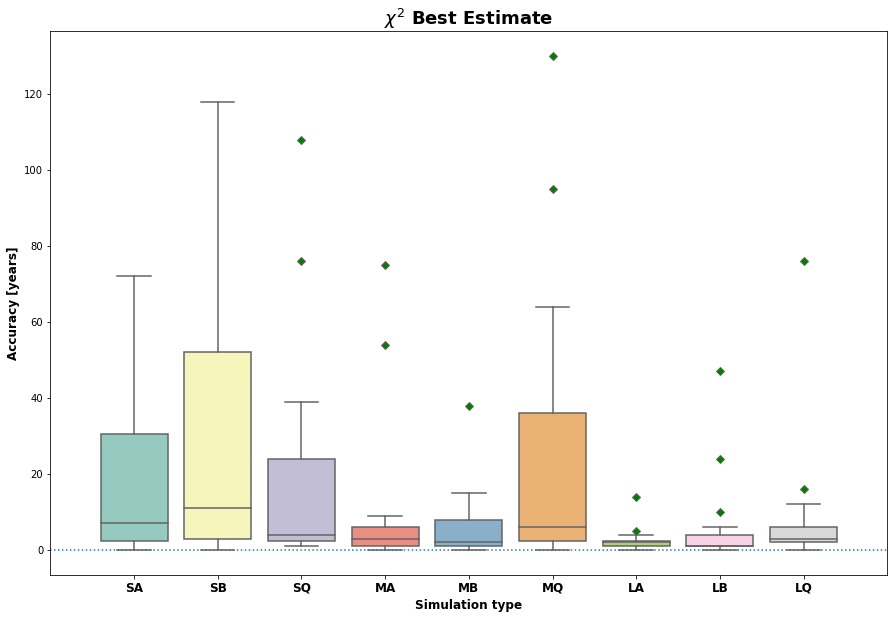

In [1005]:
# Explode the lists in the 'Chi_error' column into separate rows
df_box_chi = df.explode('Chi_error')
df_box_chi['Chi_error'] = pd.to_numeric(df_box_chi['Chi_error'])
df_box_chi['Chi_error'] = abs(df_box_chi['Chi_error'])

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(15, 10))

# Plot boxplots for each category of "type"
sns.boxplot(data=df_box_chi, x='Type', y='Chi_error', ax=ax, flierprops=dict(markerfacecolor='g', marker='D'), palette="Set3")

# Add horizontal dotted lines
ax.hlines(0, -1, 10, linestyles='dotted')

# Set labels and title
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy [years]', fontsize=12, fontweight='bold')
ax.set_xlabel('Simulation type', fontsize=12, fontweight='bold')
ax.set_title('$\chi^2$ Best Estimate ', fontsize=18, fontweight='bold')

# Set x-axis limits
ax.set_xlim(-1, 9)
#ax.set_ylim(-1,50)

# Save and show the plot
plt.savefig(f'./Figures/Overview/{formatted_datetime}/boxplot_chi_be.jpg', bbox_inches='tight', pad_inches=0.5, dpi=200)
plt.show()


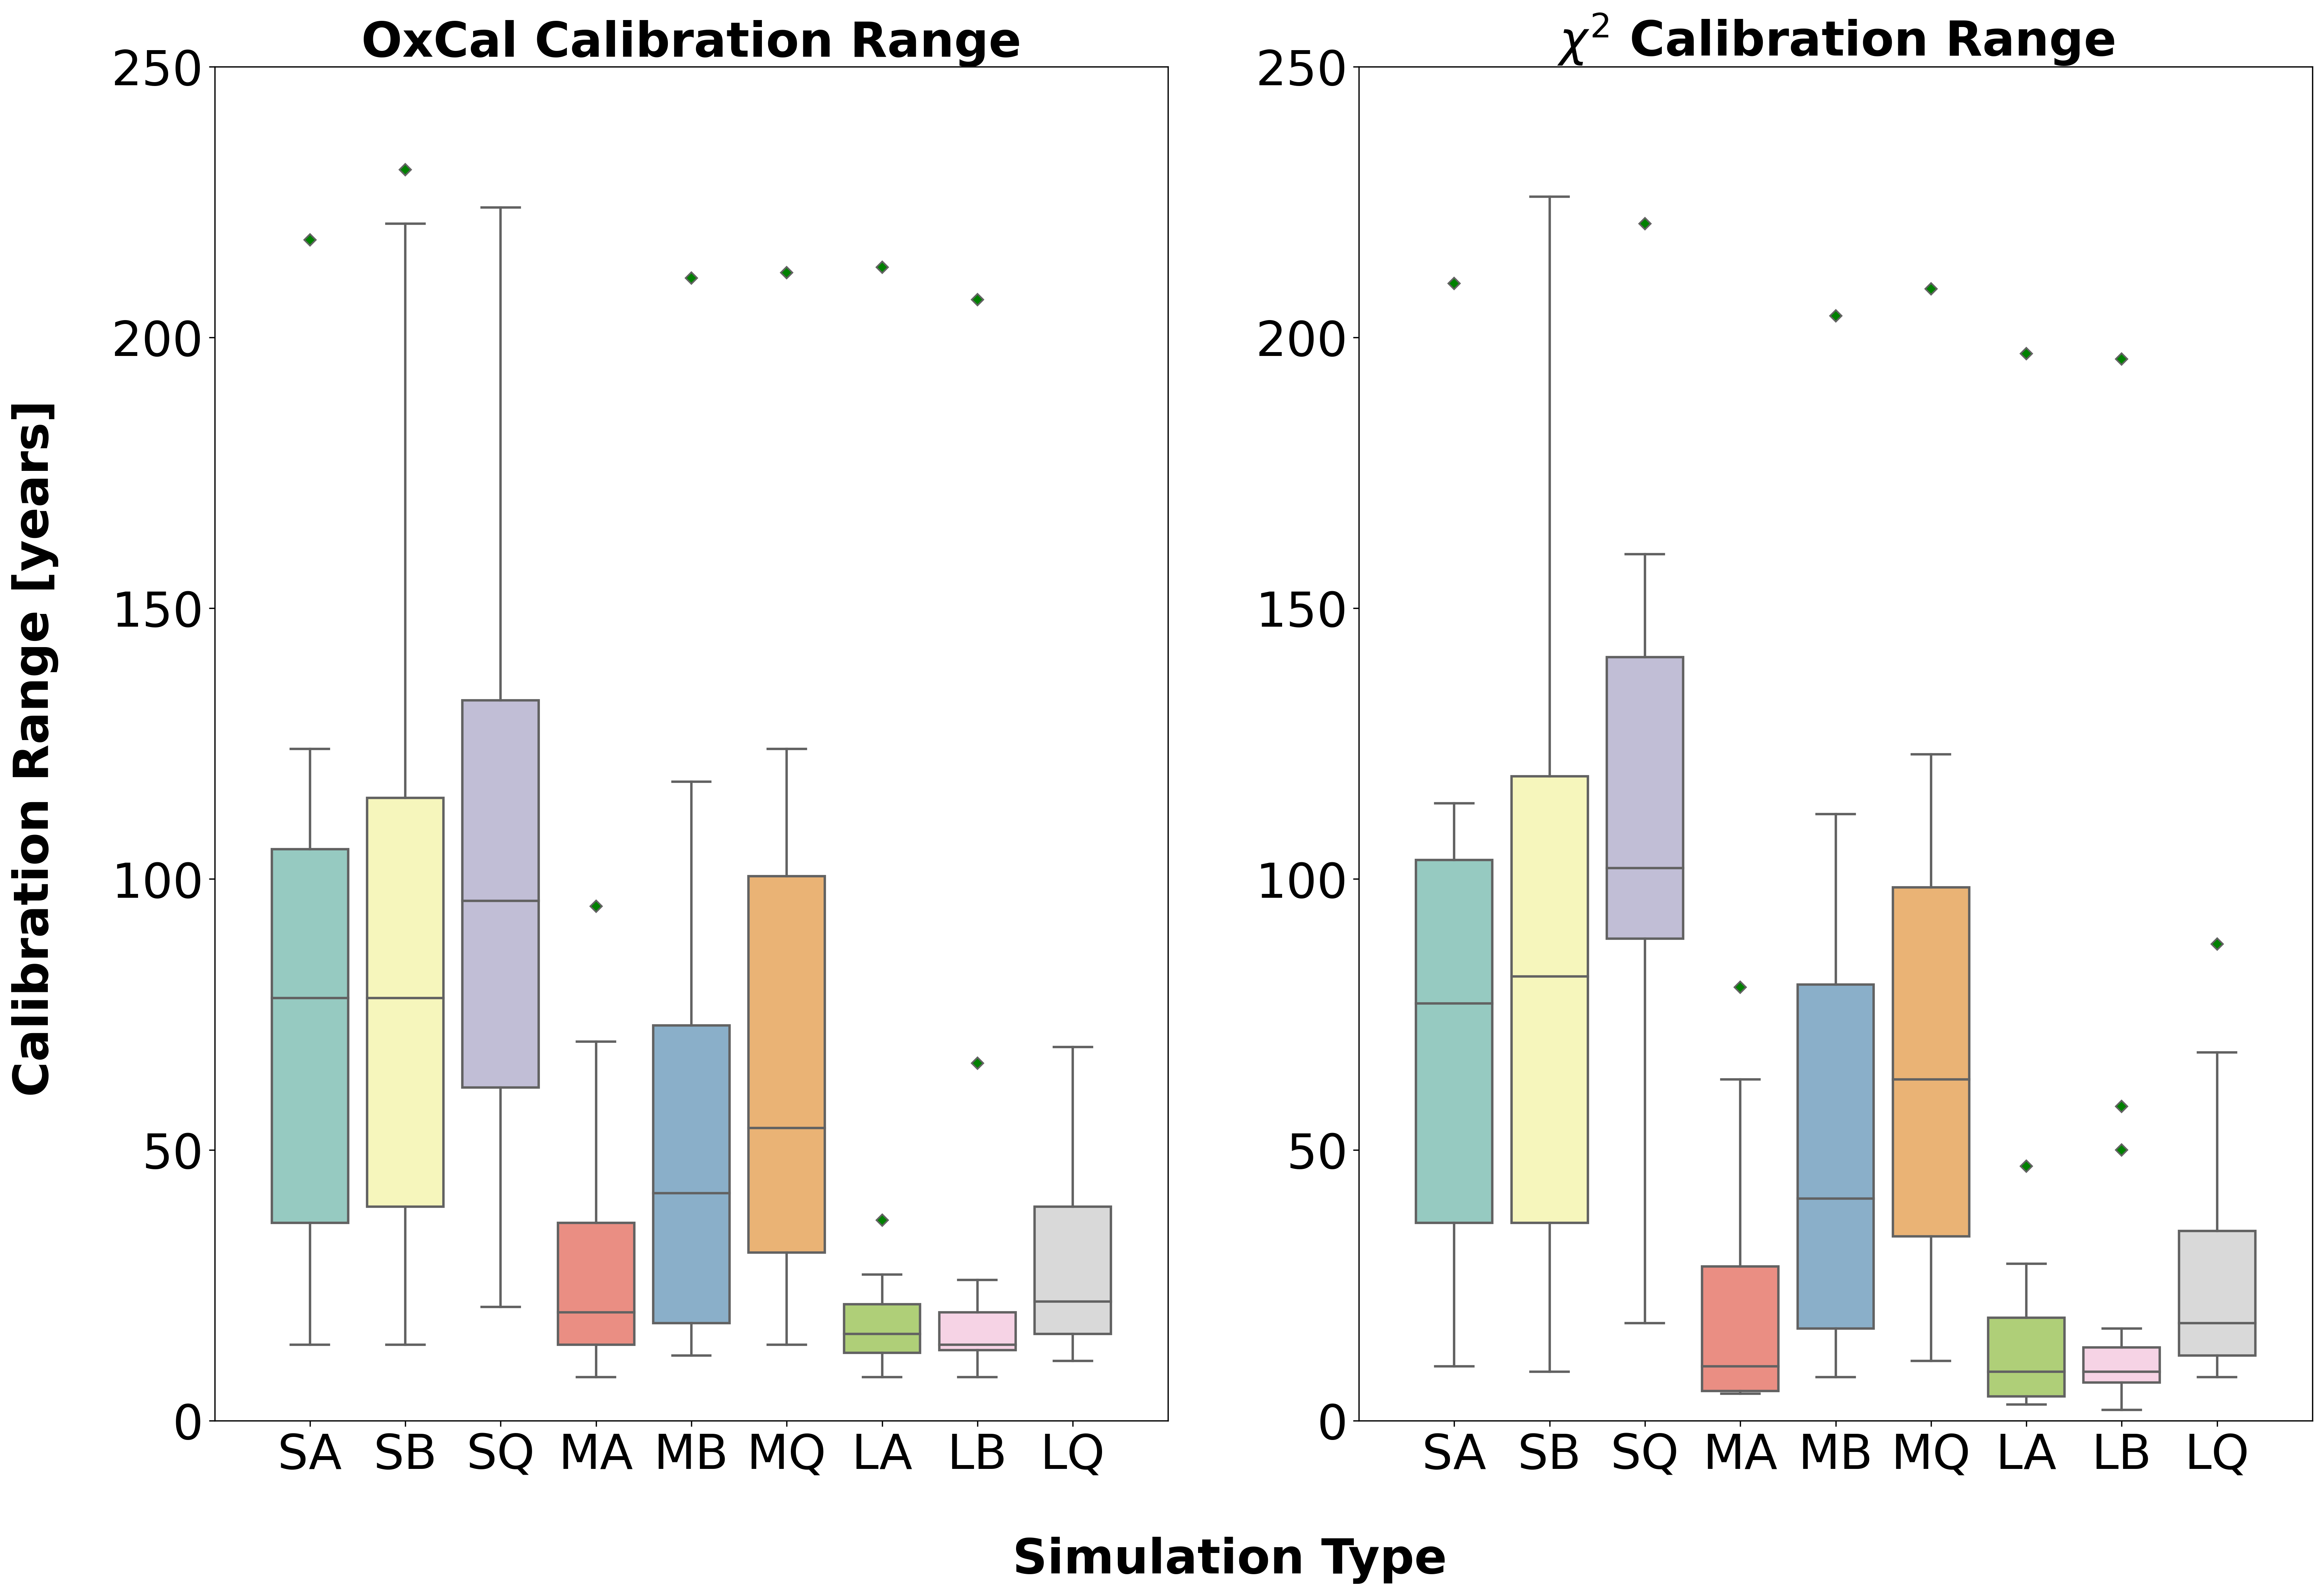

In [1006]:
########### FIGURE 1

df_box_chi_n = df.explode('Ox Range Size')
df_box_chi_s = df.explode('Chi_range_sum_size')

fig = plt.figure(figsize=(23.4,15.5), dpi=300)
fig.canvas.draw()

ax1 = plt.subplot(1,2,1)
sns.boxplot(data=df_box_chi_n, x='Type', y='Ox Range Size', ax=ax1, flierprops=dict(markerfacecolor='g', marker='D'), palette="Set3")

ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=30)
ax1.tick_params(axis='y', which='major', labelsize=30)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('OxCal Calibration Range', fontsize=30, fontweight='bold')
ax1.set_xlim(-1, 9)
ax1.set_ylim(0,250)

ax2 = plt.subplot(1,2,2)
sns.boxplot(data=df_box_chi_s, x='Type', y='Chi_range_sum_size', ax=ax2, flierprops=dict(markerfacecolor='g', marker='D'), palette="Set3")

ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=30)
ax2.tick_params(axis='y', which='major', labelsize=30)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('$\chi^2$ Calibration Range', fontsize=30, fontweight='bold')
ax2.set_xlim(-1, 9)
ax2.set_ylim(0,250)

fig.text(0.5, 0.04, 'Simulation Type', ha='center', fontsize=30, fontweight='bold')
fig.text(0.05, 0.5, 'Calibration Range [years]', va='center', rotation='vertical', fontsize=30, fontweight='bold')

plt.savefig(f'./Figures/Overview/{formatted_datetime}/boxplot_calibration_ranges.jpg', bbox_inches='tight', pad_inches=0.5, dpi=300)
plt.show()

# HEATMAPS

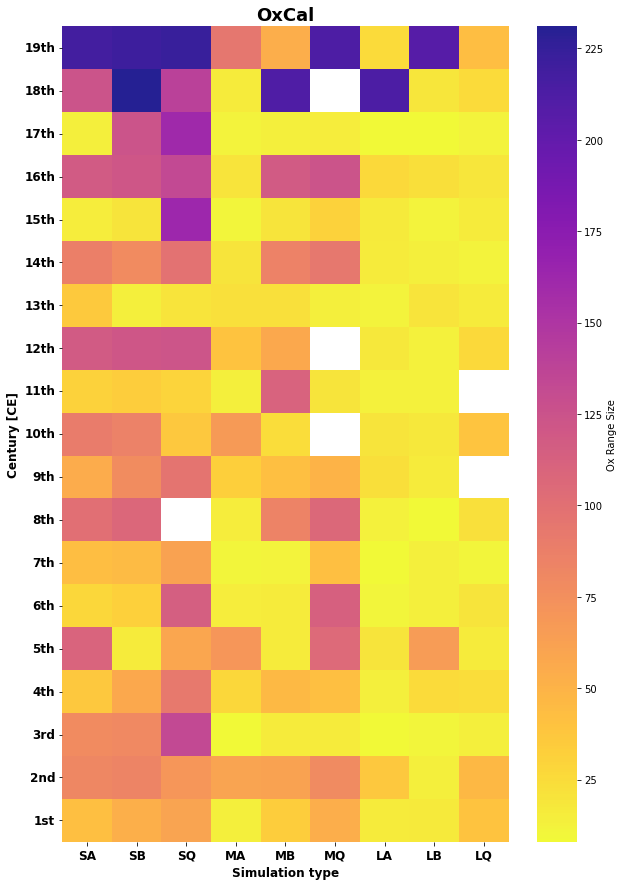

In [1007]:


# Flatten the lists in the 'Chi_error' column
df_heat_oxcal = df.explode('Ox Range Size')

# Convert the 'Chi_error' column to numeric
df_heat_oxcal['Ox Range Size'] = pd.to_numeric(df_heat_oxcal['Ox Range Size'])
df_heat_oxcal['Ox Range Size'] = abs(df_heat_oxcal['Ox Range Size'])

# Pivot the DataFrame to prepare for heatmap
heatmap_data = df_heat_oxcal.pivot_table(index='Century', columns='Type', values='Ox Range Size', aggfunc='mean')

# Define the order for x and y axes
custom_order_x = ['SA', 'SB','SQ', 'MA', 'MB', 'MQ', 'LA', 'LB', 'LQ']
custom_order_y = sorted(df['Century'].unique(), key=lambda x: int(x[:-2]), reverse=True)

#df['Century'] = df['Century'].astype(int)
#custom_order_y = sorted(df['Century'].unique(), reverse=True)  # Sorting the unique values of Century column

# Rearrange columns of heatmap_data based on custom order
heatmap_data = heatmap_data[custom_order_x]
heatmap_data = heatmap_data.reindex(custom_order_y)

# Create a mask based on the 'Ox in-Range' column
mask_fail = df_heat_oxcal.pivot_table(index='Century', columns='Type', values='Ox in-Range').astype(bool)
mask_fail = mask_fail[custom_order_x]  # Reset index before reindexing
mask_fail = mask_fail.reindex(custom_order_y)
mask_failed = ~mask_fail
mask_failed

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 15))

sns.heatmap(data=heatmap_data, cmap='plasma_r', ax=ax, cbar_kws={'label': 'Ox Range Size'},mask=mask_failed,
            xticklabels=custom_order_x, yticklabels=custom_order_y, alpha=0.9)

# Apply custom order to y axis
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight='bold', rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')

# Set labels and title
ax.set_xlabel('Simulation type', fontsize=12, fontweight='bold')
ax.set_ylabel('Century [CE]', fontsize=12, fontweight='bold')
ax.set_title('OxCal', fontsize=18, fontweight='bold')

# Save and show the plot
plt.savefig(f'./Figures/Overview/{formatted_datetime}/heatmap_oxcal.jpg', bbox_inches='tight', pad_inches=0.5, dpi=200)
plt.show()


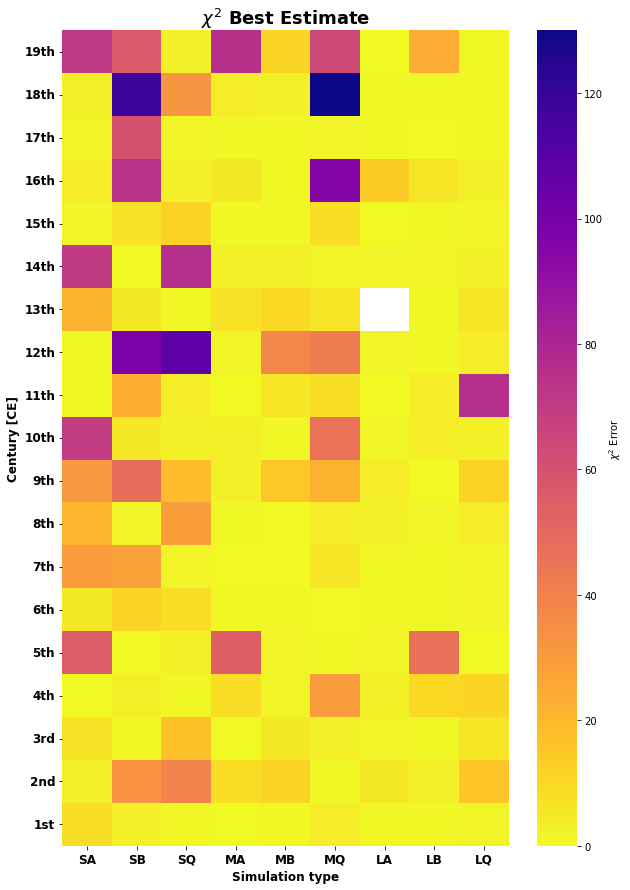

In [1008]:


# Flatten the lists in the 'Chi_error' column
df_heat_chi = df.explode('Chi_error')
df_heat_chi['Chi_error'] = pd.to_numeric(df_heat_chi['Chi_error'])
df_heat_chi['Chi_error'] = abs(df_heat_chi['Chi_error'])

# Pivot the DataFrame to prepare for heatmap
heatmap_data = df_heat_chi.pivot_table(index='Century', columns='Type', values='Chi_error', aggfunc='mean')

# Define the order for x and y axes
custom_order_x = ['SA', 'SB','SQ', 'MA', 'MB', 'MQ', 'LA', 'LB', 'LQ']
custom_order_y = sorted(df['Century'].unique(), key=lambda x: int(x[:-2]), reverse=True)

# Rearrange columns of heatmap_data based on custom order
heatmap_data = heatmap_data[custom_order_x]
heatmap_data = heatmap_data.reindex(custom_order_y)

mask_fail = df_heat_chi.pivot_table(index='Century', columns='Type', values='Chi_result', aggfunc=lambda x: x.mode()[0])
result_mapping = {'Passed': False, 'Failed': True}
mask_fail = mask_fail.applymap(lambda x: result_mapping[x])
mask_fail = mask_fail[custom_order_x]
mask_fail = mask_fail.reindex(custom_order_y)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 15))

# Plot the heatmap with custom order
sns.heatmap(data=heatmap_data, cmap='plasma_r', ax=ax, cbar_kws={'label': '$\chi^2$ Error'}, mask=mask_fail, 
            xticklabels=custom_order_x, yticklabels=custom_order_y)

# Apply custom order to y axis
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight='bold', rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')

# Set labels and title
ax.set_xlabel('Simulation type', fontsize=12, fontweight='bold')
ax.set_ylabel('Century [CE]', fontsize=12, fontweight='bold')
ax.set_title('$\chi^2$ Best Estimate', fontsize=18, fontweight='bold')

# Save and show the plot
plt.savefig(f'./Figures/Overview/{formatted_datetime}/heatmap_chi.jpg', bbox_inches='tight', pad_inches=0.5, dpi=200)
plt.show()


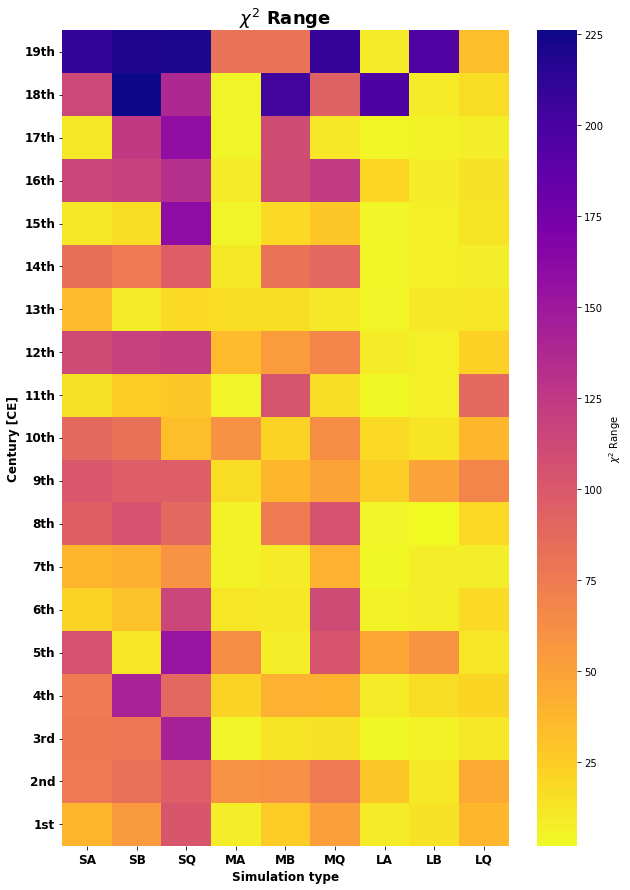

In [1009]:


# Flatten the lists in the 'Chi_error' column
df_heat_chirange = df.explode('Chi_range_sum_size')
df_heat_chirange['Chi_range_size'] = pd.to_numeric(df_heat_chirange['Chi_range_sum_size'])
df_heat_chirange['Chi_range_sum_size'] = abs(df_heat_chirange['Chi_range_sum_size'])

# Pivot the DataFrame to prepare for heatmap
heatmap_data = df_heat_chirange.pivot_table(index='Century', columns='Type', values='Chi_range_sum_size', aggfunc='mean')

# Define the order for x and y axes
custom_order_x = ['SA', 'SB','SQ', 'MA', 'MB', 'MQ', 'LA', 'LB', 'LQ']
custom_order_y = sorted(df['Century'].unique(), key=lambda x: int(x[:-2]), reverse=True)

# Rearrange columns of heatmap_data based on custom order
heatmap_data = heatmap_data[custom_order_x]
heatmap_data = heatmap_data.reindex(custom_order_y)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 15))

# Plot the heatmap with custom order
sns.heatmap(data=heatmap_data, cmap='plasma_r', ax=ax, cbar_kws={'label': '$\chi^2$ Range'}, 
            xticklabels=custom_order_x, yticklabels=custom_order_y)

# Apply custom order to y axis
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight='bold', rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')

# Set labels and title
ax.set_xlabel('Simulation type', fontsize=12, fontweight='bold')
ax.set_ylabel('Century [CE]', fontsize=12, fontweight='bold')
ax.set_title('$\chi^2$ Range', fontsize=18, fontweight='bold')

# Save and show the plot
plt.savefig(f'./Figures/Overview/{formatted_datetime}/heatmap_chi_range.jpg', bbox_inches='tight', pad_inches=0.5, dpi=200)
plt.show()


In [1010]:
finish_datetime = datetime.datetime.now()
total_time = finish_datetime - current_datetime
print(f"Total execution time: {total_time}")

Total execution time: 0:10:33.601916
